# System MTF Budget: Satellite Example

## Introduction

The Modulation Transfer Function (MTF) essentially describes the ability of an optical system to resolve fine detail. However, the system MTF is not limited to optics or the detector. Anything impacting the MTF (or, in practical terms blurring or smearing the image) should be accounted for. The final system MTF is a combination of all such factors.

In this example we will compute a sample MTF budget for the French high-res satellite Pléiades.

Sources:

- [ESA Pléiades page](https://earth.esa.int/eogateway/missions/pleiades#instruments-section)
- [eoPortal Pléiades page](https://www.eoportal.org/satellite-missions/pleiades#hiri-high-resolution-imager)

## Loading the Imager Parameters

We have to start with the opticks package import (as the notebook sometimes fails to find it).

An imager is made up of three parts: Optics, Detector and (optionally) Read-out/Write Electronics. We load the configuration files for each part and initialise the `Imager` object.

In [42]:
# If opticks import fails, try to locate the module
import os

try:
    import opticks
except ModuleNotFoundError:
    os.chdir(os.path.join("..", ".."))
    os.getcwd()

In [43]:
from pathlib import Path

from opticks.imager_model.detector import Channel
from opticks.imager_model.imager import Imager

print(f"current working directory: {Path.cwd()}")

file_directory = Path("docs", "examples", "sample_sat_pushbroom")
optics_file_path = file_directory.joinpath("optics.yaml")
detector_file_path = file_directory.joinpath("pan_detector.yaml")
rw_electronics_file_path = file_directory.joinpath("rw_electronics.yaml")

# check whether input files exist
print(f"optics file exists:  {optics_file_path.is_file()}")
print(f"detector file exists:  {detector_file_path.is_file()}")
print(f"RW electronics file exists:  {rw_electronics_file_path.is_file()}")

# Init imager object
imager = Imager.from_yaml_file(
    optics_file_path, detector_file_path, rw_electronics_file_path
)

# shorthands
optics = imager.optics
detector = imager.detector
rw_electronics = imager.rw_electronics

# select the first channel
channel: Channel = next(iter(detector.params.channels.all.values()))

current working directory: /home/egemen/Projects/opticks
optics file exists:  True
detector file exists:  True
RW electronics file exists:  True


## Imager MTF

The imager comprises the optics and the detector. The ideal optical MTF for a circular aperture and no significant aberrations.

The optics and detector MTFs can be plotted for the increasing input line frequencies. Usually the optics MTF comes out of Zemax computations or lab measurements. 

In this example however we will use the ideal optical MTF (given by the `optics.ideal_mtf()` function). We will then evaluate it for 100 intermediate line frequencies, all the way to the spatial cutoff frequency, where (by definition) no more detail can be resolved by the optics. However, the detector Nyquist frequency determines the maximum theoretical resolution that can be obtained from the imager. 

Note that the spatial cutoff frequency is also a function of the wavelength and Pléiades PAN works in the range 480 to 820 nm.

Note the widely used bands:

- blue: 450-485 nm
- green: 500-565 nm
- red: 625-750 nm
- nir: 780-2500 nm

In this example we will evaluate the Optics MTF at the limits as well as the middle of the PAN range. Then we will compute the Detector MTF and finally we will combine the 650 nm Optics MTF with the Detector MTF to obtain the Imager MTF (at 650 nm).

In [44]:
from opticks import u

import numpy as np

ref_wavelength = [480, 650, 820] * u.nm

# Generate the optics MTF data
cutoff_freq = optics.spatial_cutoff_freq(ref_wavelength)
line_freq_unit = cutoff_freq.u

input_line_freq = np.linspace(0.0, cutoff_freq.m, 100) * line_freq_unit
input_line_freq_mid = input_line_freq[:, 1]

optical_mtf = optics.ideal_mtf(input_line_freq, ref_wavelength)
optical_mtf_mid = optics.ideal_mtf(input_line_freq_mid, ref_wavelength[1])  # at 650 nm

# Generate the detector Nyquist limit
nyq_freq = channel.nyquist_freq(with_binning=True)

# Generate the detector MTF data (use 650 nm input line data)

detector_mtf = channel.detector_mtf(input_line_freq_mid, with_binning=True)

# Generate the imager MTF data at 650 nm (imager = optics x detector)
imager_mtf = optical_mtf_mid * detector_mtf

Now that we have generated the data points, we can create the MTF plot.

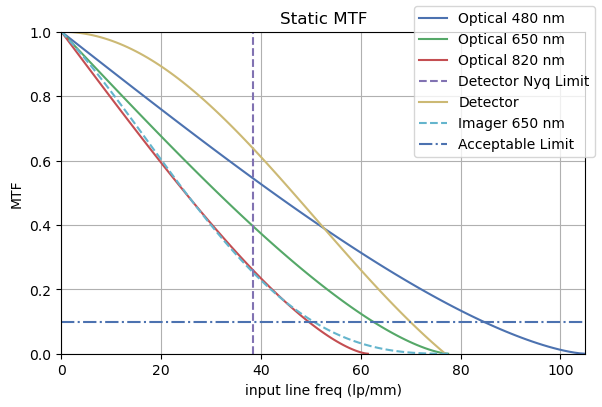

In [45]:
from matplotlib import pyplot as plt

# pint support to matplotlib
u.setup_matplotlib()


# plot the MTF data
# -----------------
fig, ax1 = plt.subplots()

# select data
ax1.plot(
    input_line_freq,
    optical_mtf,
    label=[
        f"Optical {ref_wavelength[0]:~P}",
        f"Optical {ref_wavelength[1]:~P}",
        f"Optical {ref_wavelength[2]:~P}",
    ],
)
ax1.plot([nyq_freq.m, nyq_freq.m], [0, 1], label="Detector Nyq Limit", linestyle="--")
ax1.plot(input_line_freq_mid, detector_mtf, label="Detector")

ax1.plot(
    input_line_freq_mid,
    imager_mtf,
    label=f"Imager {ref_wavelength[1]:~P}",
    linestyle="--",
)

ax1.plot(
    [0.0, input_line_freq.max().m],
    [0.1, 0.1],
    label="Acceptable Limit",
    linestyle="-.",
)

# set decorators
ax1.set_xlabel(f"input line freq ({line_freq_unit:~P})")
ax1.set_ylabel("MTF")
ax1.set_title("Static MTF")

fig.legend()


# set plot formatting
ax1.xaxis.grid(True)
ax1.yaxis.grid(True)
ax1.set_xlim(0, cutoff_freq.max())
ax1.set_ylim(0, 1)
fig.tight_layout()

fig.set_figheight(4)
fig.set_figwidth(6)


plt.style.use("seaborn-v0_8-deep")


plt.show()

From the plot, certain observations can be made:
- As the PAN band has a very broad frequency range, the incoming light wavelength impacts the MTF performance very significantly. The blue limit of the band (480 nm), detail is resolved significantly better than the red in the middle of the band (650 nm) and the near-infrared limit at the end (820 nm).
- While the optics can resolve detail for higher input line frequencies, the pixel size limits the MTF (Nyquist limit) and does not allow input line frequencies above 38 line pairs/mm.
- While not a hard rule, an System MTF of 0.1 at the Nyquist Limit is desired. This ensures that the fine detail in the scene is resolved at a certain minimum sharpness. In this example, the Imager MTF (at 650 nm) is around 0.25. This is a good value, but it should be kept in mind that the optics are assumed ideal and the computed value can be called the "Static MTF". On the satellite, it will be subject to other effects due to several sources of motion, degrading the image quality further.     


In [46]:
# compute Q (for the three wavelengths)
q = (
    ref_wavelength * optics.f_number / channel.pixel_pitch(with_binning=True)
).to_reduced_units()

print(f"Optical Q : {np.array_str(q.m, precision=5)}")

Optical Q : [0.73307 0.99269 1.25232]


The Optical Q value can be computed for the three reference wavelengths (the limits and the middle of PAN). It can be observed that the middle 650 nm has a Q value that is practically equal to 1 and even the 820 nm edge wavelength has a Q value of 1.25.

## Bringing It All Together

The individual contributors above can be visualised in an "MTF Plot", essentially describing the individual contributors for all input frequencies, as well as the total system MTF. 